In [1]:
## The Original Code is : https://github.com/kaklin/sq-limit

## To use in Google Colab :

#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive
#!git clone https://github.com/kaklin/sq-limit
#%cd ./sq-limit

# <br>Settings & Data Load<br>

In [1]:
%cd ./

import os
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

module_dir = os.getcwd()+os.sep

# AMZ : AM zero condition / ASTMG173 : Earth standard condition
mode=['AMZ.CSV','ASTMG173.csv']
spectrumS = np.loadtxt(module_dir + mode[0], delimiter=',', skiprows=1)
spectrumE = np.loadtxt(module_dir + mode[1], delimiter=',', skiprows=1)

pd_S = pd.DataFrame(spectrumS, columns = ['Wavelength(nm)', 'Irradiance'])
print('\nAMZ.CSV File Contents\n\n',pd_S[:5])

C:\Users\김미르\Documents\GitHub\perovskite_PCE_calc

AMZ.CSV File Contents

    Wavelength(nm)  Irradiance
0           119.5    0.000062
1           120.5    0.000561
2           121.5    0.004900
3           122.5    0.001180
4           123.5    0.000048


In [2]:
# Constants
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant')

Tcell = 273  # Temperature (kelvin)
Egap = 1.6  # electron volts (Default : silicon 1.1eV)

# <br>Spectrum Graph Comparison<br>

Total spectrum AM0 irriadiance   : 1366.49381 W/m^2
Total spectrum AM2.5 irriadiance : 1000.47070 W/m^2


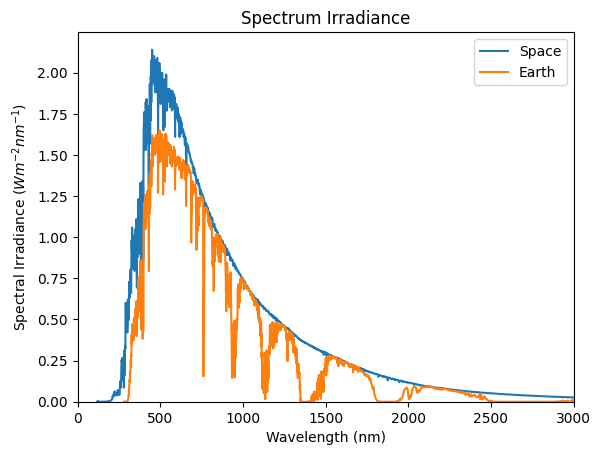

In [3]:
# S:space / E : earth
spectrumS = np.loadtxt(module_dir + mode[0], delimiter=',', skiprows=1)
spectrumE = np.loadtxt(module_dir + mode[1], delimiter=',', skiprows=1)

plt.plot(spectrumS[:, 0], spectrumS[:, 1], label='Space')
plt.plot(spectrumE[:, 0], spectrumE[:, 1], label='Earth')

plt.xlim(left=0,right=3000)
plt.ylim(bottom=0)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Irradiance ($Wm^{-2}nm^{-1}$)')
plt.title('Spectrum Irradiance')
plt.legend()

original_irradianceS = np.trapz(spectrumS[:, 1], spectrumS[:, 0])
original_irradianceE = np.trapz(spectrumE[:, 1], spectrumE[:, 0])

print('Total spectrum AM0 irriadiance   : {:.5f} W/m^2'.format(original_irradianceS))
print('Total spectrum AM2.5 irriadiance : {:.5f} W/m^2'.format(original_irradianceE))

In [4]:
def convert_spectrum(spectrum):
    """
    Spectrum input        x: Wavelength (nm),   y: Irradiance (W/m2/nm)
    Converted output      x: Energy (eV),       y: Number of photons (Np/m2/s/dE)
    """
    converted = np.copy(spectrum)
    converted[:, 0] = converted[:, 0] * 1e-9  # wavelength to m
    converted[:, 1] = converted[:, 1] / 1e-9  # irradiance to W/m2/m (from W/m2/nm)

    E = h * c / converted[:, 0]
    d_lambda_d_E = h * c / E**2
    converted[:, 1] = converted[:, 1] * d_lambda_d_E * e / E
    converted[:, 0] = E / e
    return converted

If everything went okay this should be pretty close to the number from before...
Space : Original 1366.49381 W/m^2	-->>  Converted 1366.48019 W/m^2
Earth : Original 1000.47070 W/m^2	-->>  Converted 1000.47073 W/m^2


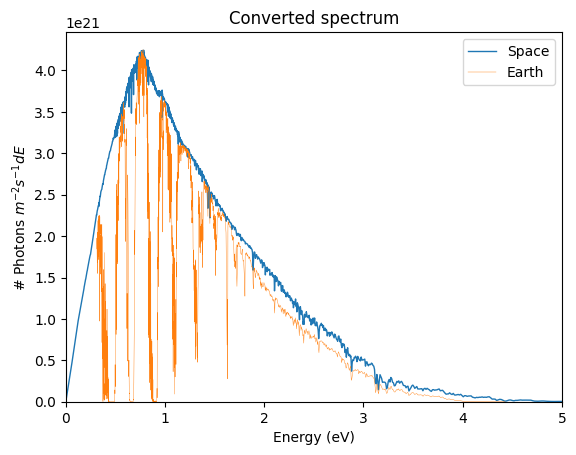

In [5]:
photon_spectrumS = convert_spectrum(spectrumS)
photon_spectrumE = convert_spectrum(spectrumE)

plt.plot(photon_spectrumS[:,0], photon_spectrumS[:,1], label='Space', linewidth=1)
plt.plot(photon_spectrumE[:,0], photon_spectrumE[:,1], label='Earth', linewidth=0.3)
plt.xlim(left=0, right=5)
plt.ylim(bottom=0)
plt.xlabel('Energy (eV)')
plt.ylabel('# Photons $m^{-2}s^{-1}dE$')
plt.legend()
plt.title('Converted spectrum')

# Checking the Accuracy of Converting by Re-converting
photon_irradianceS = np.trapz(photon_spectrumS[::-1, 1] * photon_spectrumS[::-1, 0],
                          photon_spectrumS[::-1, 0]) * e
photon_irradianceE = np.trapz(photon_spectrumE[::-1, 1] * photon_spectrumE[::-1, 0],
                          photon_spectrumE[::-1, 0]) * e

print('If everything went okay this should be pretty close to the number from before...')
print('Space : Original {:.5f} W/m^2\t-->>  Converted {:.5f} W/m^2'
      .format(original_irradianceS, photon_irradianceS))
print('Earth : Original {:.5f} W/m^2\t-->>  Converted {:.5f} W/m^2'
      .format(original_irradianceE, photon_irradianceE))

# Calculating # of Photons

In [12]:
def photons_above_bandgap(egap, spectrum):
    """Counts number of photons above given bandgap"""
    indexes = np.where(spectrum[:, 0] > egap)
    y = spectrum[indexes, 1][0]
    x = spectrum[indexes, 0][0]
    return np.trapz(y[::-1], x[::-1])

def photons_above_bandgap_plot(egap, spectrum1, spectrum2):
    #Plot bandgap vs # of photons above bandgap
    spectra=[spectrum1, spectrum2]
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    copied_spectra = [np.copy(spectrum1), np.copy(spectrum2)]
    names = ['Space','Earth']
    for i, ax in enumerate(axes):
        spectrum = copied_spectra[i]
        for row in spectrum:
            row[1] = photons_above_bandgap(row[0], spectra[i])
        ax.plot(spectrum[:, 0], spectrum[:, 1])
        p_above_egap = photons_above_bandgap(egap, spectra[i])
        ax.plot([egap], [p_above_egap], 'ro')
        ax.text(egap+0.05, p_above_egap, '{}eV, {:.2}'.format(egap, p_above_egap))
        ax.set_xlabel('$E_{gap}$ (eV)')
        ax.set_ylabel('# Photons $m^{-2}s^{-1}$')
        ax.set_title(f'# of above-Eg photons for {names[i]}',pad=20)
    plt.show()

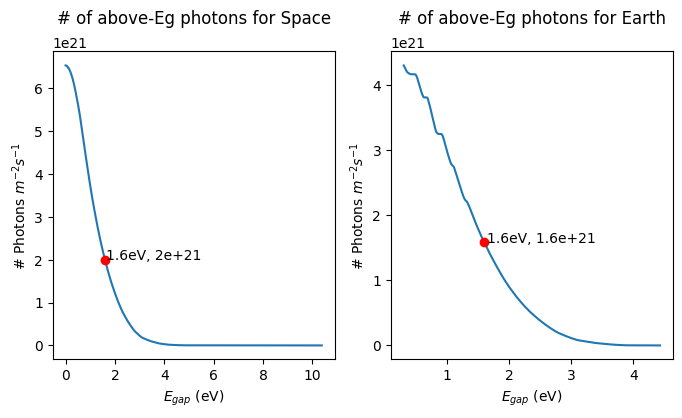

In [13]:
photons_above_bandgap_plot(Egap,photon_spectrumS,photon_spectrumE)

# <br>Calculating Jsc  &  Voc  &  I-V Curve<br>

In [68]:
def rr0(egap, Temperature,spectrum):
    k_eV = k / e
    h_eV = h / e
    const = (2 * np.pi) / (c**2 * h_eV**3)
    E = spectrum[::-1, ]  # in increasing order of bandgap energy
    egap_index = np.where(E[:, 0] >= egap)
    numerator = E[:, 0]**2
    exponential_in = E[:, 0] / (k_eV * Temperature)
    denominator = np.exp(exponential_in) - 1
    integrand = numerator / denominator
    integral = np.trapz(integrand[egap_index], E[egap_index, 0])
    result = const * integral
    return result[0]

def recomb_rate(egap, Temperature, spectrum, voltage):
    return e * rr0(egap, Temperature, spectrum) * np.exp(e * voltage / (k * Temperature))

def current_density(egap, Temperature, spectrum, voltage):
    return e * (photons_above_bandgap(egap, spectrum) - rr0(egap, Temperature, spectrum)
                * np.exp(e * voltage / (k * Temperature)))

def jsc(egap, Temperature, spectrum):
    return current_density(egap, Temperature, spectrum, 0)

def voc(egap, Temperature, spectrum):
    return (k * Temperature / e) * np.log(photons_above_bandgap(egap, spectrum)
                                          / rr0(egap, Temperature, spectrum))

In [69]:
print('At space,')
print('A material with a bandgap of %.2f will have an:' % Egap)
print('Ideal short circuit current: ', jsc(Egap, Tcell, photon_spectrumS), 'A/m^2')
print('Ideal open circuit  voltage: ', voc(Egap, Tcell, photon_spectrumS), 'V')
print('\n')
print('At Earth,')
print('A material with a bandgap of %.2f will have an:' % Egap)
print('Ideal short circuit current: ', jsc(Egap, Tcell, photon_spectrumE), 'A/m^2')
print('Ideal open circuit  voltage: ', voc(Egap, Tcell, photon_spectrumE), 'V')

At space,
A material with a bandgap of 1.60 will have an:
Ideal short circuit current:  319.085205242855 A/m^2
Ideal open circuit  voltage:  1.3606361241349612 V


At Earth,
A material with a bandgap of 1.60 will have an:
Ideal short circuit current:  254.03491275997487 A/m^2
Ideal open circuit  voltage:  1.3533061763863674 V


In [80]:
def plot_spectrum(ax, egap, temperature, spectrum, label, calc_func, y_label):
    a = np.copy(spectrum)
    for row in a:
        row[1] = calc_func(row[0], temperature, spectrum)
    ax.plot(a[:, 0], a[:, 1], label=label)
    p_above_egap = calc_func(egap, temperature, spectrum)
    ax.plot([egap], [p_above_egap], 'ro')
    ax.text(egap + 0.05, p_above_egap, '{}eV, {:.4}'.format(egap, p_above_egap))
    ax.set_xlabel('$E_{gap}$ (eV)')
    ax.set_ylabel(y_label)
    ax.legend()
    ax.set_xlim((egap-1, egap+1))

def ideal_plots(egap, temperature, spectrum1, spectrum2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    plot_spectrum(ax1, egap, temperature, spectrum1, label1, jsc, '$J_{SC}$ $Am^{-2}$')
    plot_spectrum(ax1, egap, temperature, spectrum2, label2, jsc, '$J_{SC}$ $Am^{-2}$')
    ax1.set_title('Ideal short-circuit current')
    ax1.set_xlim((np.maximum(egap-0.5,0), egap+0.5))
    ax1.set_ylim(bottom=0)

    plot_spectrum(ax2, egap, temperature, spectrum1, label1, voc, '$V_{OC}$ (V)')
    plot_spectrum(ax2, egap, temperature, spectrum2, label2, voc, '$V_{OC}$ (V)')
    ax2.set_title('Ideal open-circuit voltage')
    ax2.set_xlim((np.maximum(egap-0.5,0), egap+0.5))
    ax2.set_ylim((np.maximum(egap-0.5,0), egap+0.5))
    plt.show()

C:\Users\김미르\AppData\Local\Temp\ipykernel_22748\3459707092.py:26: RuntimeWarning: invalid value encountered in scalar divide
  return (k * Temperature / e) * np.log(photons_above_bandgap(egap, spectrum)
C:\Users\김미르\AppData\Local\Temp\ipykernel_22748\3459707092.py:26: RuntimeWarning: divide by zero encountered in log
  return (k * Temperature / e) * np.log(photons_above_bandgap(egap, spectrum)


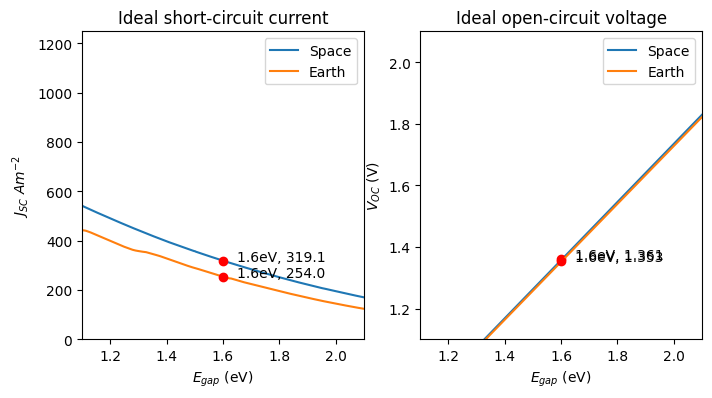

In [81]:
ideal_plots(Egap, Tcell, photon_spectrumS, photon_spectrumE, 'Space', 'Earth')

In [128]:
def plot_iv_curve(ax, egap, temperature, spectrum, label):
    v_open = voc(egap, temperature, spectrum)
    v = np.linspace(0, v_open, 100)
    i = current_density(egap, temperature, spectrum, v)
    p = v * i

    ax.plot(v, i, label=f'I - V curve')
    ax2 = ax.twinx()
    ax2.plot(v, p, color='orange', label=f'P - V curve')
    ax.set_xlabel('Voltage (V)')
    ax.set_ylabel('Current density $J$ ($Am^{-2}$)')
    ax2.set_ylabel('Power generated ($W$)')
    ax.legend(loc=3, fontsize=10)
    ax2.legend(loc=4, fontsize=10)

def plot_iv_curves(egap, temperature, spectra, labels):
    fig, axes = plt.subplots(1, len(spectra), figsize=(10, 4))
    for ax, spectrum, label in zip(axes, spectra, labels):
        plot_iv_curve(ax, egap, temperature, spectrum, label)
        plt.title(label)
    plt.subplots_adjust(wspace=0.5)
    plt.show()

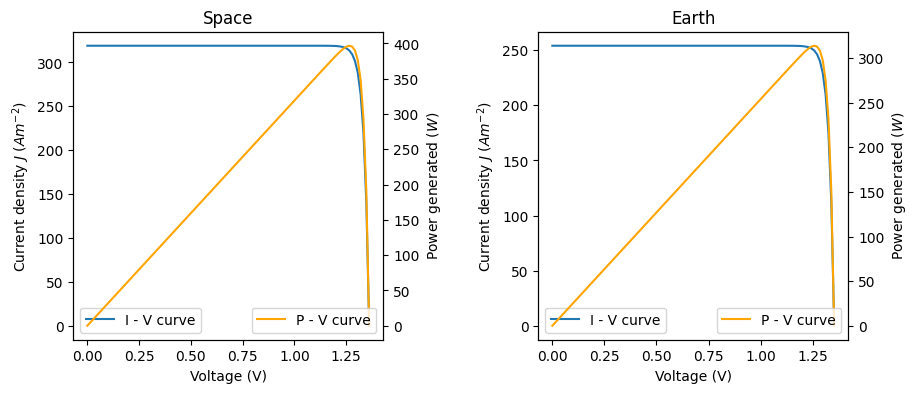

In [129]:
plot_iv_curves(Egap, Tcell, [photon_spectrumS, photon_spectrumE], ['Space', 'Earth'])

# <br>Calculating Cell Efficiency<br>

In [130]:
def v_at_mpp(egap, temperature, spectrum):
    v_open = voc(egap, temperature, spectrum)
    v = np.linspace(0, v_open)
    index = np.where(v * current_density(egap, temperature, spectrum, v)
                     == max(v * current_density(egap, temperature, spectrum, v)))
    return v[index][0]

def max_power(egap, temperature, spectrum):
    v_open = voc(egap, temperature, spectrum)
    v = np.linspace(0, v_open)
    index = np.where(v * current_density(egap, temperature, spectrum, v)
                     == max(v * current_density(egap, temperature, spectrum, v)))
    return max(v * current_density(egap, temperature, spectrum, v))

def j_at_mpp(egap, temperature, spectrum):
    return max_power(egap, temperature, spectrum) / v_at_mpp(egap, temperature, spectrum)

def max_eff(egap, temperature, spectrum):
    irradiance =  np.trapz(spectrum[::-1, 1] * e * spectrum[::-1, 0], spectrum[::-1, 0])
    return max_power(egap, temperature, spectrum) / irradiance

For Space, Optimal Bandgap : 1.2398 , Max Efficiency : 31.2589%
++ Ideal Efficiency for Bandgap 1.60 eV : 28.96% 

For Earth, Optimal Bandgap : 1.3375 , Max Efficiency : 34.8049%
++ Ideal Efficiency for Bandgap 1.60 eV : 31.31% 



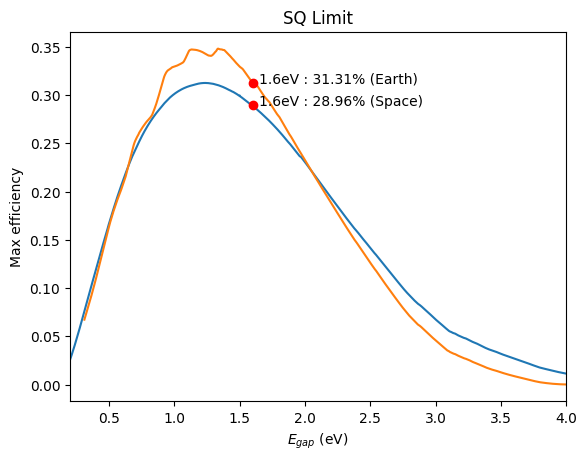

In [156]:
def sq_limit_plot(egap, temperature, spectrum, label):
    a = np.copy(spectrum)
    for row in a[2:]:
        row[1] = max_eff(row[0],  temperature, spectrum)
    plt.plot(a[2:, 0], a[2:, 1])

    opt_Eg_index = np.argmax(a[2:, 1])
    opt_Eg=spectrum[opt_Eg_index,0]
    max_Eff=max_eff(opt_Eg, temperature, spectrum)

    print('For {}, Optimal Bandgap : {:.4f} , Max Efficiency : {:.4f}%'.format(label, opt_Eg, max_Eff*100))

    print('++ Ideal Efficiency for Bandgap {:.2f} eV : {:.4}% \n'.format(egap, max_eff(egap, temperature, spectrum)*100))

    p_above_egap = max_eff(egap, temperature, spectrum)
    plt.plot([egap], [p_above_egap], 'ro')
    plt.text(egap+0.05, p_above_egap, '{}eV : {:.2f}% ({})'.format(egap, p_above_egap*100, label))
    plt.xlim((0.2,4))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('Max efficiency')
    plt.title('SQ Limit')

sq_limit_plot(1.6, Tcell, photon_spectrumS, 'Space')
sq_limit_plot(1.6, Tcell, photon_spectrumE, 'Earth')